# Confusion Scheme Learning
### Training a CNN in PyTorch to find a phase transition critical temperature using data generated from Quantum Monte Carlo simulations 

Here we illustrate how the <b>"learning by confusion''</b> (LBC) technique can be used to find the transition temperature $\beta_c$ in the square lattice Holstein model, below which a long-range ordered charge density wave (CDW) phase occurs. Our Hybrid Quantum Monte Carlo (HMC) simulations give us many different kinds of measurements. Some of this data is imaginary-time resolved (e.g. density-density correlations), and we can also store "snapshots" of local quantities (e.g. electron density per site) taken periodically throughout the measurement phase of a simulation. 

In this notebook, we will specifically look at snapshots of the phonon field (i.e. the set of phonon dispacement variables in the lattice) for a $12 \times 12$ lattice with $144$ sites. Saving snapshots every $n_s$ measurement sweeps, we store $n_{\textrm{snap}} = n_{\textrm{meas}}/n_s$ configurations per inverse temperature $\beta$, and perform HMC simulations at $45$ fixed temperatures in the range $\beta \in [1.0, 12.0]$. After processing this data into a single csv file, our training data has dimension $(9000, 144)$ (for $n_\textrm{snap}=200$, $n_s=50$, $n_\textrm{meas}=10000$). Each row contains data from a single snapshot, which we can reshape into a (greyscale) $12 \times 12$ image to use as input for our CNN. 

More traditional techniques for determining $\beta_c$ (e.g. performing simulations for a range of lattice sizes followed by finite-size scaling of a chosen order parameter) yield a value of $\beta_c = 6.0 \pm 0.1$ (for the Holstein model parameters we study here, i.e. $\omega_0/t=1$ and $\lambda_D=0.25$). Please refer to the reference <i>Phonon Dispersion and the Competition between Pairing and Charge Order</i>, Costa <i>et. al.</i> [Phys. Rev. Lett 120, 187003 (2018)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.187003) for further details.

Below we will find that the LBC method can discover this critical temperature ($\beta_c \approx 6$) without having to perform a finite-size scaling, or even needing to know in advance any information about the order parameter!

However, snapshots of the phonon field are just one set of measurements we can take during a Quantum Monte Carlo simulation of the Holstein model. What kind of measurements work best for discovering the critical point? In another notebook, <b>Methodology_and_Results.ipynb</b>, we explore the efficacy of various sets of training data in locating the phase transition with confusion scheme learning.

### 1. Import Libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### 2. Read in data (phonon snapshots). Display some samples:

In [4]:
data = np.loadtxt('data/L12_phonon_position_snapshots_ns50.csv', delimiter=',')
X = data[:, :-1]
T = data[:, -1]

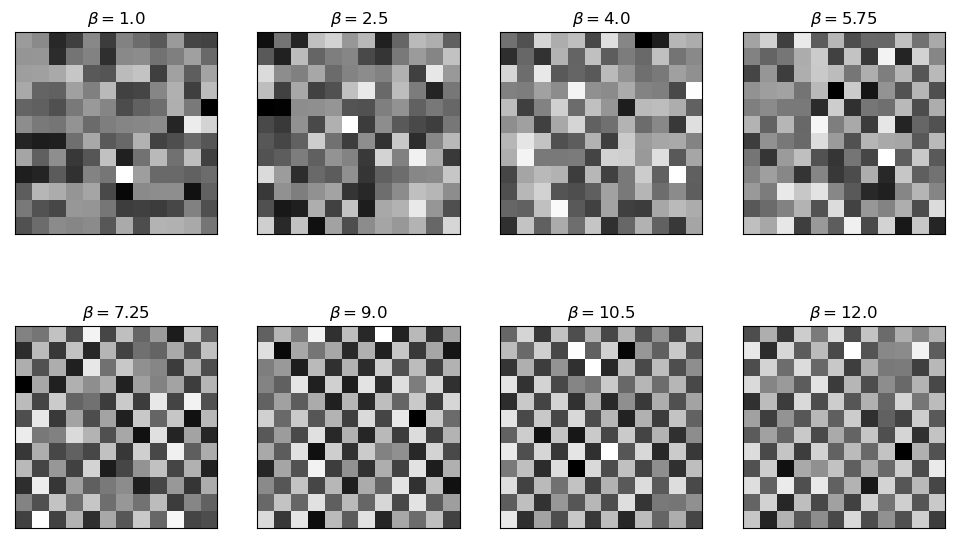

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(12, 7))
index = 0

for i in range(2):
    for j in range(4):

        axs[i, j].imshow(X[index*1285].reshape(12, 12), cmap="binary", origin='lower')

        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(r'$\beta = $' + str(T[index*1285]))

        index += 1

### 3. Test/train split:

In [17]:
X_train_array, X_test_array, T_train_array, T_test_array = train_test_split(X, T, test_size=0.2, random_state=1, shuffle=True)
X_train_array, X_val_array, T_train_array, T_val_array = train_test_split(X_train_array, T_train_array, test_size=0.25, random_state=1, shuffle=True)

X_train_array = np.reshape(X_train_array, (X_train_array.shape[0], 1, 12, 12))
X_val_array = np.reshape(X_val_array, (X_val_array.shape[0], 1, 12, 12))
X_test_array = np.reshape(X_test_array, (X_test_array.shape[0], 1, 12, 12))

### 4. Training step:

In [21]:
def train(model, num_epochs, train_dl, valid_dl):

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    best_val_loss = np.inf
    patience = 10
    
    for epoch in range(num_epochs):

        for x_batch, y_batch in train_dl:
            
            pred = model(x_batch)[:, 0]
                        
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()

            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:

                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch + 1}    Train Accuracy: {accuracy_hist_train[epoch]:.4f}   Train Loss: {loss_hist_train[epoch]:.4f}     Valid Accuracy: {accuracy_hist_valid[epoch]:.4f}   Valid Loss: {loss_hist_valid[epoch]:.4f}')
        
        if loss_hist_valid[epoch] < best_val_loss:
            
            best_val_loss = loss_hist_valid[epoch]
            early_stop_counter = patience
            best_model = model
        
        else:    
            early_stop_counter -= 1
            
        if early_stop_counter == 0:
            break
            
    print(f'\n Best validation accuracy = {np.max(accuracy_hist_valid)} \n\n')
            
    return loss_hist_train[:epoch+1], accuracy_hist_train[:epoch+1], loss_hist_valid[:epoch+1], accuracy_hist_valid[:epoch+1], best_model

### 5. Confusion scheme:

Let us choose $23$ candidate critical (inverse) temperatures in the range $[1.0, 12.0]$ to sweep through. For each guess for $\beta_c$, we will assign target labels $y=1$ to snapshot configurations with $\beta < \beta_c$ (disordered phase), and target labels $y=0$ to configurations with $\beta_c \geq \beta_c$ (ordered phase).

In [ ]:
T_min = 1
T_max = 12
Tc_values = np.linspace(T_min, T_max, 23)

After assigning target labels and preparing DataLoaders (with batch_size = $32$), we feed our snapshots to a Convolutional Neural Network (CNN) implemented in PyTorch using nn.Sequential.

<b>Architecture of ConvNet:</b> 2 convolution layers followed by 2 fully connected layers.

Input dimensions in [N, C, H, W] format: [batch_size, 1, 12, 12].

Note: images have one channel only.

1. **Conv2d:** $32$ filters with $\textrm{kernel_size}=3$; "same" padding. Output dimensions: $[\textrm{batch_size}, 32, 12, 12]$.
2. **ReLU** activation.
3. **MaxPool2d** with $\textrm{kernel_size}=2$: Output dimensions: $[\textrm{batch_size}, 32, 6, 6]$.
4. **Conv2d:** $64$ filters with $\textrm{kernel_size}=3$; "same" padding. Output dimensions: $[\textrm{batch_size}, 64, 6, 6]$.
5. **ReLU** activation.
6. **MaxPool2d** with $\textrm{kernel_size}=2$: Output dimensions: $[\textrm{batch_size}, 64, 3, 3]$.
7. **nn.Flatten**. Output dimensions: $[\textrm{batch_size}, 64\times3\times3]$ = $[\textrm{batch_size}, 576]$.
8. **nn.Linear** with $\textrm{out_features}=256$. Output dimensions = $[\textrm{batch_size}, 256]$.
9. **ReLU** activation.
10. **Dropout** (probability $p=0.1$).
11. **nn.Linear** with $\textrm{out_features}=1$. Output dimensions = $[\textrm{batch_size}, 1]$.
12. **nn.Sigmoid**. Output dimensions = $[\textrm{batch_size}, 1]$ (Tensor of class probabilities for each sample in batch).

<b>Loss function:</b> Binary cross-entropy (nn.BCEloss)

<b>Optimizer:</b> Adam with weight decay ($L2$ regularization)

In [23]:
test_accuracies = []

for Tc in Tc_values:
    
    if Tc == T_max:
        y_train_array = (T_train_array <= Tc).astype(int)
        y_test_array = (T_test_array <= Tc).astype(int)
        y_val_array = (T_val_array <= Tc).astype(int)
    else:
        y_train_array = (T_train_array < Tc).astype(int)
        y_test_array = (T_test_array < Tc).astype(int)
        y_val_array = (T_val_array < Tc).astype(int)
    
    
    X_train = torch.tensor(X_train_array, dtype=torch.float32)
    X_test = torch.tensor(X_test_array, dtype=torch.float32)
    X_val = torch.tensor(X_val_array, dtype=torch.float32)
    y_train = torch.tensor(y_train_array, dtype=torch.float32)
    y_test = torch.tensor(y_test_array, dtype=torch.float32)
    y_val = torch.tensor(y_val_array, dtype=torch.float32)
    
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_val, y_val)
    
    batch_size = 32
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size, shuffle=True)
    
    model = nn.Sequential(

        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(576, 256),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        nn.Linear(256, 1),
        nn.Sigmoid()

    )
    
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  
    
    num_epochs = 20
    torch.manual_seed(1)
    
    loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid, best_model = train(model, num_epochs, train_dl, valid_dl)
    
    pred = best_model(X_test)[:, 0]
    is_correct = ((pred >= 0.5).float() == y_test).int()
    test_accuracy = (is_correct.sum() / is_correct.shape[0]).item()
    print(f'Tc guess = {Tc}, Test set accuracy = {test_accuracy} \n\n\n')
    
    test_accuracies.append(test_accuracy)
    

Epoch 1    Train Accuracy: 0.9941   Train Loss: 0.0085     Valid Accuracy: 1.0000   Valid Loss: 0.0000
Epoch 2    Train Accuracy: 1.0000   Train Loss: 0.0000     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 3    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 4    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 5    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 6    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 7    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 8    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 9    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 10    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accurac

Epoch 13    Train Accuracy: 0.9880   Train Loss: 0.0338     Valid Accuracy: 0.9611   Valid Loss: 0.0924
Epoch 14    Train Accuracy: 0.9891   Train Loss: 0.0306     Valid Accuracy: 0.9578   Valid Loss: 0.1177
Epoch 15    Train Accuracy: 0.9817   Train Loss: 0.0425     Valid Accuracy: 0.9528   Valid Loss: 0.1232
Epoch 16    Train Accuracy: 0.9898   Train Loss: 0.0297     Valid Accuracy: 0.9561   Valid Loss: 0.1226
Epoch 17    Train Accuracy: 0.9928   Train Loss: 0.0216     Valid Accuracy: 0.9589   Valid Loss: 0.1024
Epoch 18    Train Accuracy: 0.9970   Train Loss: 0.0141     Valid Accuracy: 0.9594   Valid Loss: 0.1171
Epoch 19    Train Accuracy: 0.9972   Train Loss: 0.0105     Valid Accuracy: 0.9556   Valid Loss: 0.1389

 Best validation accuracy = 0.9661111235618591 


Tc guess = 3.0, Test set accuracy = 0.9544444680213928 



Epoch 1    Train Accuracy: 0.8874   Train Loss: 0.2208     Valid Accuracy: 0.9367   Valid Loss: 0.1441
Epoch 2    Train Accuracy: 0.9391   Train Loss: 0.1317     

Epoch 17    Train Accuracy: 0.9931   Train Loss: 0.0214     Valid Accuracy: 0.9600   Valid Loss: 0.1281
Epoch 18    Train Accuracy: 0.9983   Train Loss: 0.0103     Valid Accuracy: 0.9500   Valid Loss: 0.1341
Epoch 19    Train Accuracy: 0.9980   Train Loss: 0.0098     Valid Accuracy: 0.9639   Valid Loss: 0.1119
Epoch 20    Train Accuracy: 0.9994   Train Loss: 0.0086     Valid Accuracy: 0.9628   Valid Loss: 0.1169

 Best validation accuracy = 0.9688888788223267 


Tc guess = 5.0, Test set accuracy = 0.9561111330986023 



Epoch 1    Train Accuracy: 0.9472   Train Loss: 0.1335     Valid Accuracy: 0.9628   Valid Loss: 0.0920
Epoch 2    Train Accuracy: 0.9706   Train Loss: 0.0778     Valid Accuracy: 0.9578   Valid Loss: 0.1060
Epoch 3    Train Accuracy: 0.9707   Train Loss: 0.0754     Valid Accuracy: 0.9661   Valid Loss: 0.0932
Epoch 4    Train Accuracy: 0.9720   Train Loss: 0.0717     Valid Accuracy: 0.9628   Valid Loss: 0.0904
Epoch 5    Train Accuracy: 0.9709   Train Loss: 0.0756     Val

Epoch 9    Train Accuracy: 0.9476   Train Loss: 0.1272     Valid Accuracy: 0.9461   Valid Loss: 0.1308
Epoch 10    Train Accuracy: 0.9520   Train Loss: 0.1173     Valid Accuracy: 0.9411   Valid Loss: 0.1436
Epoch 11    Train Accuracy: 0.9548   Train Loss: 0.1131     Valid Accuracy: 0.9461   Valid Loss: 0.1286
Epoch 12    Train Accuracy: 0.9578   Train Loss: 0.1101     Valid Accuracy: 0.9433   Valid Loss: 0.1429
Epoch 13    Train Accuracy: 0.9589   Train Loss: 0.1028     Valid Accuracy: 0.9456   Valid Loss: 0.1307
Epoch 14    Train Accuracy: 0.9607   Train Loss: 0.0980     Valid Accuracy: 0.9461   Valid Loss: 0.1289
Epoch 15    Train Accuracy: 0.9650   Train Loss: 0.0920     Valid Accuracy: 0.9417   Valid Loss: 0.1343

 Best validation accuracy = 0.9472222328186035 


Tc guess = 7.5, Test set accuracy = 0.9405555725097656 



Epoch 1    Train Accuracy: 0.8881   Train Loss: 0.2440     Valid Accuracy: 0.9239   Valid Loss: 0.1752
Epoch 2    Train Accuracy: 0.9252   Train Loss: 0.1787     V

Epoch 10    Train Accuracy: 0.9298   Train Loss: 0.1610     Valid Accuracy: 0.9072   Valid Loss: 0.2029
Epoch 11    Train Accuracy: 0.9363   Train Loss: 0.1490     Valid Accuracy: 0.9206   Valid Loss: 0.1747
Epoch 12    Train Accuracy: 0.9433   Train Loss: 0.1362     Valid Accuracy: 0.9194   Valid Loss: 0.1813
Epoch 13    Train Accuracy: 0.9407   Train Loss: 0.1339     Valid Accuracy: 0.9094   Valid Loss: 0.2036
Epoch 14    Train Accuracy: 0.9450   Train Loss: 0.1280     Valid Accuracy: 0.9144   Valid Loss: 0.1877
Epoch 15    Train Accuracy: 0.9524   Train Loss: 0.1157     Valid Accuracy: 0.9111   Valid Loss: 0.1950
Epoch 16    Train Accuracy: 0.9583   Train Loss: 0.1042     Valid Accuracy: 0.9128   Valid Loss: 0.1928
Epoch 17    Train Accuracy: 0.9431   Train Loss: 0.1277     Valid Accuracy: 0.8867   Valid Loss: 0.2346
Epoch 18    Train Accuracy: 0.9574   Train Loss: 0.1000     Valid Accuracy: 0.8994   Valid Loss: 0.2417
Epoch 19    Train Accuracy: 0.9680   Train Loss: 0.0836     Vali

Epoch 1    Train Accuracy: 0.9941   Train Loss: 0.0096     Valid Accuracy: 1.0000   Valid Loss: 0.0000
Epoch 2    Train Accuracy: 1.0000   Train Loss: 0.0000     Valid Accuracy: 1.0000   Valid Loss: 0.0000
Epoch 3    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 4    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 5    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 6    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 7    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 8    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 9    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accuracy: 1.0000   Valid Loss: 0.0001
Epoch 10    Train Accuracy: 1.0000   Train Loss: 0.0001     Valid Accurac

### 6. Result: Classification accuracy vs. $\beta_c$

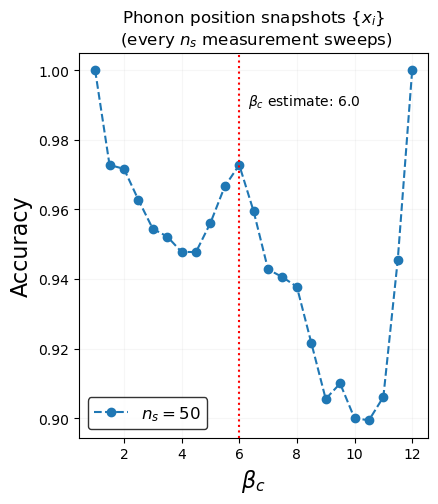

In [56]:
beta_c_estimate = Tc_values[2:-2][np.argmax(test_accuracies[2:-2])]

plt.figure(figsize=(4.5, 5))
plt.plot(Tc_values, test_accuracies, '--o', label=r'$n_s=50$')
plt.grid(alpha=0.1)
plt.axvline(x=beta_c_estimate, linestyle='dotted', color='red')
plt.legend(frameon=True, edgecolor='k', fontsize=12)
plt.text(x=beta_c_estimate+0.3, y=0.99, s=r'$\beta_c$' + f' estimate: {beta_c_estimate}')
plt.title('Phonon position snapshots ' + r'$\{ x_{i} \} $' +  '\n (every ' + r'$n_s$' + ' measurement sweeps)')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel(r'$\beta_c$', fontsize=16)
plt.show()

Here we observe the characteristic $W$ peak expected in the LBC method. It occurs at $\beta_c \approx 6$, which agrees quite well with the value known for the square lattice Holstein model ($\beta_c = 6.0 \pm 0.1$) [[Phys. Rev. Lett. 120, 187003]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.187003). 

However, snapshots of the phonon field are just one set of measurements we can take during a Quantum Monte Carlo simulation of the Holstein model. What kind of measurements work best for discovering the critical point? In another notebook, <b>Methodology_and_Results.ipynb</b>, we explore the efficacy of various sets of training data in locating the phase transition with confusion scheme learning.